<a href="https://colab.research.google.com/github/zarrinan/DS-Sprint-01-Dealing-With-Data/blob/master/module1-afirstlookatdata/LS_DS_111_A_First_Look_at_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [0]:
# TODO - we'll be doing this live, taking requests
1+1
# and reproducing what it is to look up and learn things

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

In [1]:
# TODO - your code here
# Use what we did live in lecture as an example


###TensorFlow###

import tensorflow as tf
# Create a graph
g = tf.Graph()

with g.as_default():
  x = tf.constant(112, name="x_const")
  y = tf.constant(4, name="y_const")
  my_sum = tf.add(x, y, name="x_y_sum")
  
  # Create a session
  with tf.Session() as sess:
    print(my_sum.eval())

116


In [0]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf

from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [0]:
boston_housing = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv", sep=",")
boston_housing.head()
boston_housing = boston_housing.reindex(
    np.random.permutation(boston_housing.index))

In [0]:
def preprocess_features(boston_housing):
  """Prepares input features from California housing data set."""

 
  selected_features = boston_housing[
    ["crim",
     "zn",
     "indus",
     "nox",
     "rm",
     "age",
     "dis",
     "rad",
     "tax",
    "ptratio",
    ]]
  processed_features = selected_features.copy()
 
  return processed_features

def preprocess_targets(boston_housing):
  """Prepares target features (i.e., labels) from California housing data set."""

  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["medv"] = (
    boston_housing["medv"] )
  return output_targets

In [26]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(boston_housing.head(400))# I would rather call it training_features
training_targets = preprocess_targets(boston_housing.head(400))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(boston_housing.tail(100))# I would rather call it validation_features
validation_targets = preprocess_targets(boston_housing.tail(100))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,crim,zn,indus,nox,rm,age,dis,rad,tax,ptratio
count,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
mean,3.3,11.6,11.1,0.6,6.3,68.2,3.8,9.4,406.3,18.4
std,7.4,23.3,6.9,0.1,0.7,28.2,2.2,8.6,167.8,2.2
min,0.0,0.0,0.5,0.4,3.6,6.0,1.1,1.0,187.0,12.6
25%,0.1,0.0,5.1,0.4,5.9,42.6,2.1,4.0,279.0,17.2
50%,0.2,0.0,9.1,0.5,6.2,76.8,3.2,5.0,330.0,19.0
75%,3.4,20.0,18.1,0.6,6.6,94.1,5.3,24.0,666.0,20.2
max,67.9,95.0,27.7,0.9,8.7,100.0,12.1,24.0,711.0,22.0


Validation examples summary:


,crim,zn,indus,nox,rm,age,dis,rad,tax,ptratio
count,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
mean,4.7,10.9,11.2,0.6,6.2,69.3,3.7,9.9,412.3,18.5
std,12.4,23.9,6.6,0.1,0.7,28.0,1.9,9.0,172.6,2.1
min,0.0,0.0,1.3,0.4,3.9,2.9,1.3,1.0,188.0,12.6
25%,0.1,0.0,5.8,0.5,5.9,49.0,2.0,4.0,280.5,17.4
50%,0.3,0.0,9.8,0.5,6.2,77.3,3.4,5.0,311.0,19.1
75%,4.4,0.0,18.1,0.6,6.6,93.0,4.9,24.0,666.0,20.2
max,89.0,100.0,27.7,0.9,8.7,100.0,9.2,24.0,711.0,21.2


Training targets summary:


,medv
count,400.0
mean,22.9
std,9.4
min,5.0
25%,16.9
50%,21.4
75%,25.1
max,50.0


Validation targets summary:


,medv
count,100.0
mean,21.5
std,8.1
min,5.6
25%,17.3
50%,20.2
75%,23.9
max,50.0


In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns."""

 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model."""
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model."""
  

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
  
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["medv"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["medv"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["medv"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 12.42
  period 01 : 11.52
  period 02 : 11.05
  period 03 : 10.70
  period 04 : 10.46
  period 05 : 10.32
  period 06 : 10.04
  period 07 : 9.95
  period 08 : 9.84
  period 09 : 9.82
Model training finished.


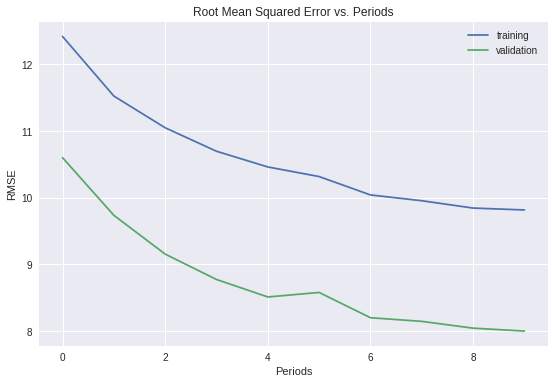

In [34]:
_ = train_model(
    learning_rate=0.01,
    steps=100,
    batch_size=10,
    feature_columns=construct_feature_columns(training_examples),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

2.  What was the most challenging part of what you did?

3.  What was the most interesting thing you learned?

4.  What area would you like to explore with more time?




I've tried to build a linear regression model using python TensorFlow library by Google, so that this model, after learning initial amount of data (training data)  would be able to predict results, close to actual ones, on validation data.The dataset I've used is a Boston Housing data, which, in my example, includes: 
- cr - per capita crime rate by town., 
- zn  - proportion of residential land zoned for lots over 25,000 sq.ft.
- indus - proportion of non-retail business acres per town.
- nox - nitrogen oxides concentration (parts per 10 million).
- rm - average number of rooms per dwelling.
- age - proportion of owner-occupied units built prior to 1940.     
- dis - weighted mean of distances to five Boston employment centres.
- rad - index of accessibility to radial highways.
- tax - full-value property-tax rate per USD 10,000.
- ptratio - pupil-teacher ratio by town.
- medv - median value of owner-occupied homes in USD 1000s .
where the "medv", the result value that the model was trying to predict. 

I can't say it was very successful, but it's the first time I've tried to build such a model for this data.
The most challenging part for me was to find the right link to upload the data. I will continue to work on this model, will tweak it to improve the results.
The most exciting part for me was to see the graph and that the model actually worked! I definitely would like to explore TensorFlow with more time and build some cool project using it.

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about

In [41]:
### Assignment from TK ###
store_names = pd.Series(['Grow Mart,', 'Plant Depot', 'Trees’R’U'])
foundation_year = pd.Series([1973, 1973, 1985])
store_revenue = pd.Series([265, 302, 123])
store_expenses = pd.Series([183, 240, 130])
stores = pd.DataFrame({ 'Store name': store_names, 'Foundation year': foundation_year, 'Store revenue': store_revenue, 'Store expenses': store_expenses })
stores

,Foundation year,Store expenses,Store name,Store revenue
0,1973,183,"Grow Mart,",265
1,1973,240,Plant Depot,302
2,1985,130,Trees’R’U,123


In [42]:
stores['is_profitable'] = (stores['Store revenue'] - stores['Store expenses']).apply(lambda val: val > 0)
stores

,Foundation year,Store expenses,Store name,Store revenue,is_profitable
0,1973,183,"Grow Mart,",265,True
1,1973,240,Plant Depot,302,True
2,1985,130,Trees’R’U,123,False
